Обрабатываем данные, полученные с сайта ЧГК. Сохраняем следующие данные:
*   ID и ФИО игроков
*   Данные турнира: ID, состав команд, маска ответов, количество вопросов
за 2019 год
*   Данные турнира: ID, состав команд за 2020 год


In [ ]:
import pickle
import pandas as pd
import numpy as np
import random
from  scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression as LR
from scipy.stats import spearmanr, kendalltau
import statistics
from matplotlib import pyplot as plt

In [ ]:


players_file = "/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/players.pkl"
results_file = ("/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/results.pkl")
tournaments_file = ("/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/tournaments.pkl")

with open(players_file, 'rb') as fin:
     players = pickle.load(fin)

with open(tournaments_file, 'rb') as fin:
     tournaments = pickle.load(fin)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = '/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/datachgk'

In [ ]:
with open(results_file, 'rb') as fin:
     results = pickle.load(fin)

In [ ]:
print(tournaments[1])

{'id': 1, 'name': 'Чемпионат Южного Кавказа', 'dateStart': '2003-07-25T00:00:00+04:00', 'dateEnd': '2003-07-27T00:00:00+04:00', 'type': {'id': 2, 'name': 'Обычный'}, 'season': '/seasons/1', 'orgcommittee': [], 'synchData': None, 'questionQty': None}


In [ ]:
tournaments_data = pd.DataFrame.from_dict(tournaments, orient='index')#.rename(columns={0:'Qunatity'}))


In [ ]:
results_data = pd.DataFrame.from_dict(results, orient='index')#.rename(columns={0:'Qunatity'}))

In [ ]:
tournaments_data['dateStart'] = pd.to_datetime(tournaments_data['dateStart'], format="%Y-%m-%dT%H:%M:%S") #2003-07-25T00:00:00+04:00

In [ ]:
#dates = tournaments_data['dateStart'].tolist()
tournaments_data['dateStart'] = tournaments_data['dateStart'].values.astype('datetime64[Y]') #tournaments_data.dateStart.dt.to_period('Y')# pd.DatetimeIndex(tournaments_data['dateStart']).year)
#ids_2019 = list(filter(lambda i : dates[i-1].year == 2019, tournaments_data['id'].tolist()))
datayear = tournaments_data['dateStart']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


In [ ]:
tournaments_data['dateStart'] = list(datayear)

In [ ]:
data19 = tournaments_data[tournaments_data['dateStart'] == '2019-01-01']
data20 = tournaments_data[tournaments_data['dateStart'] == '2020-01-01']
with open(filename,'wb') as f:
    pickle.dump(data19,f)
    pickle.dump(data20,f)

In [ ]:
with open(filename, 'rb') as fin:
     data19 = pickle.load(fin)
     data20 = pickle.load(fin)


In [ ]:
import pandas as pd
nquestions = {}
player_to_team = {}


In [ ]:
import numpy as np
import random
def most_frequent(List):
    return max(set(List), key = List.count)

def get_results_of_tournament(id):

  
  result = pd.DataFrame(columns = ['id', 'name', 'sostav','mask'])
  if id not in results.keys():
    return result
  teams = results[id] #list
  nquest =  0
  for i in  tournaments[id]['questionQty'].keys():
    nquest += tournaments[id]['questionQty'][i]
  #print(nquest)
  result['id'] = [team['team']['id'] for team in teams]
  result['name'] = [team['team']['name'] for team in teams]
  result['mask'] = [team['mask'] if 'mask' in team.keys() else "" for team in teams] 
  result['position'] = [team['position'] if 'position' in team.keys() else 10000 for team in teams]
  result = result[(result['mask'] is not None) &(result['position'] != 10000) & (result['mask'] != "")    ]
  sostav = []
  result["len"] = result["mask"].apply(lambda x: 0 if x is None else len(x))
  result = result[result["len"] == nquest].reset_index()
  #print(result.shape)

  
  teamids = result['id'].tolist()
  for team in teams:
    if team['team']['id'] not in teamids:
      continue
    ss = []
    for players in team['teamMembers']:
       #ss.update({players['player']['id'] : players['rating']})
       ss.append(players['player']['id'])
       player_to_team.update({(players['player']['id'], id) :team['team']['id'] })
    sostav.append(ss)
  result['sostav'] = sostav
  masks = result['mask'].tolist()#mask_first
 
  if len(masks) == 0:
     return pd.DataFrame()
  length = list(map(len, masks))
  

  len_min = min(length)
  len_max = max(length)
  len_mode = most_frequent(length)
  nquestions.update({id : len_min})
  
  return result




In [ ]:
ids_2019 = data19['id'].tolist()
ids_2020 = data20['id'].tolist()

In [ ]:
print(len(ids_2019))
print(len(ids_2020))

689
416


In [ ]:
def get_info_year(ids_year):
  list_players = set()
  players_info = {}
  tournament_info = {}
  for id in ids_year:
  #print(i)
    result_data = get_results_of_tournament(id)
    if result_data.empty:
       continue
    tournament_info.update({id : result_data})
    temp = result_data['sostav'].tolist()
    for ids_players in temp:
      for id_player in ids_players:
        if id_player not in players_info:
          players_info.update({id_player: [id]})
        else:
          players_info[id_player].append(id)
      list_players.update(ids_players)
  return tournament_info, list(list_players), players_info
  
  

In [ ]:
import pandas as pd
nquestions = {}
player_to_team = {}
players_info = {}
tournament_info, list_players_2019, players_info =  get_info_year(ids_2019)
with open(filename,'ab') as f:
    pickle.dump(tournament_info,f)
    pickle.dump(players_info,f)
    pickle.dump(nquestions,f)
#print(list_players_2019)

In [ ]:
ids = sorted(players_info.keys(), 
               key=lambda id: len(players_info[id]),
               reverse=True)
 
with open(filename,'ab') as f:
    pickle.dump(ids,f)
    

In [ ]:
index_player = {id: idx for idx, id in enumerate(ids)}
with open(filename,'ab') as f:
    pickle.dump(index_player,f)

Для построение baseline модели используем упрощенное предположение, что результат команды является также и результатом каждого игрока в команде. Составляем логистическую регрессию, где векторами являются two-hotcoding вектора, длина которых равна количеству всех игроков в 2019 году + количество всех вопросов в турнирах 2019 года. Единицы стоят на местах, соответствующих положению игрока и положению вопроса в этом векторе.
Обучаем регрессию на всех комбинациях игрок-вопрос в турнирах 2019 года. Весами в данной модели будут "силы" игрока и "сложности" вопросов

In [ ]:
from  scipy.sparse import csr_matrix

p_q_to_index = {}

def get_matrix(ids):
   turs = []
   w = 0
   h = 0
   
   for id in ids:#[0:idmax]:
     for id_tur in players_info[id]:
       if id_tur not in turs:
         turs.append(id_tur)
   
   
   cur_h = 0
   cur_w = 0
   cases = 0
   k = 0
   data = []
   row = []
   columns = []
   cur_w = len(ids)
   column_names = {}
   target = []
   
   for id_tur in turs:
     #print(id_tur)
     tournament_info[id_tur].index
     id_teams =  tournament_info[id_tur]['id'].tolist()
     #print(id_teams)


     for i in range(tournament_info[id_tur].shape[0]):
       players_in_team = tournament_info[id_tur].loc[i, 'sostav']
       mask = tournament_info[id_tur].loc[i, "mask"]
       cases += nquestions[id_tur] * len(players_in_team)
       if mask is None:
           continue
       if (len(players_in_team) == 0):
          continue    
       for player in players_in_team:
         for q in range(nquestions[id_tur]):
           column_names.update({cur_w + q : str(id_tur) + "_" + str(q)})
         for q in range(nquestions[id_tur]):
           data.append(1)
           columns.append(index_player[player])
           row.append(cur_h)
           data.append(1)
           columns.append(cur_w + q)
           row.append(cur_h)
           target.append(mask[q])
           p_q_to_index.update({(index_player[player], cur_w + q) : cur_h})
           cur_h += 1
           
     cur_w += nquestions[id_tur]    
   
   matrix = csr_matrix((data, (row, columns)))
   
   return cases, matrix, column_names, target

cases, matrix, column_names, target = get_matrix(ids)
 

In [ ]:
with open(filename,'ab') as f:
    pickle.dump(matrix,f)
    pickle.dump(p_q_to_index, f)
  

In [ ]:
def change_target(c):
  if c not in ['0', '1']:
    return 0
  else:
    return int(c)  
target1 = list(map(change_target, target))    

In [ ]:
with open(filename,'ab') as f:
    pickle.dump(target1,f)

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
model = LR(solver = 'saga').fit(matrix, target1)
 

In [ ]:
model0 = model

In [ ]:
with open(filename,'ab') as f:
    pickle.dump(model0,f)

В результате обучения модели получим веса $p_i$ и сложности вопросов $q_j$, а так же общее смещение для всех игроков $b$. 
  Вероятность того, что i-й игрок ответит на вопрос $q_j$ будет равна:
  $$ P(p_i, q_j) = \sigma(p_i + q_j + b)$$

In [ ]:

players_info_2020 = {}
tournament_info_2020, list_players_2020, players_info_2020 =  get_info_year(ids_2020)

with open(filename,'ab') as f:
    pickle.dump(tournament_info_2020,f)

In [ ]:
ids_2020_new = []
for id in ids_2020:
  if id in tournament_info_2020.keys():
    if tournament_info_2020[id].empty:
      continue
    else: 
      ids_2020_new.append(id)

with open(filename,'ab') as f:
    pickle.dump(ids_2020_new,f)

In [ ]:
print(len(ids_2020_new))

170


In [ ]:
from scipy.stats import spearmanr
def prob_answer(s, q, b):
  return (1/(1 + np.exp(-(s + q  + b))))


def get_mean_range_coeff(ids_turs1, strengths):
  #ss = []
  coeff1 = []
  coeff2 = []
  #dict_right = {}
  #dict_pred1 = {}
  for id in ids_turs1:#[0 : 1]:
    range_right = tournament_info_2020[id]['position'].tolist()
    #dict_right.update({id : })
    ids_right = tournament_info_2020[id]['id'].tolist()
    range_pred1 = []
    range_pred2 = []
    for i in range(tournament_info_2020[id].shape[0]):
      players = tournament_info_2020[id].loc[i, 'sostav']
    
      command_strength1 = 0
      command_strength2 = 1
      for player in players:
        if player in index_player.keys():
          #ss.append(player)
          #command_strength1 += strengths[index_player[player]] 
          command_strength2 *=  (1 - prob_answer(strengths[index_player[player]], 0, model.intercept_))
      #range_pred1.append(command_strength1)
      range_pred2.append(command_strength2)
    
    #range_pred1.reverse()
    
    #c1, _ = #spearmanr(range_right, range_pred1)
    c1, _ = kendalltau(range_right, range_pred2)
    c2, _ = spearmanr(range_right, range_pred2)
   
    
    if not (np.isnan(c1) or  np.isnan(c2)):
       coeff1.append(c1)
       coeff2.append(c2)

  return coeff1, coeff2#,   range_right, ids_right, range_pred1

      


В качестве оценки работы baseline модели рассмотрим две метрики. Во-первых отранжируем команду, по показателям, рассчитанным следующим образом:
*   Как сумму рассчитанных сил игроков
*   Как вероятность правильного ответа команды
Вероятность, того, что команда правильно ответит на вопрос в зависимости от сил участников команды и сложности вопроса q:
$$P = 1 - \prod\limits_{i = 1}(1 - \sigma(p_i + q + b))$$
Первый вариант дает всегда меньшую корреляцию с правильным ранжированием, поэтому оставляем только второй.
Силу вопроса выбираем произвольной.



Получаем следующие показатели усредненных ранговых корреляций Спирмана и Кендалла для турниров 2020 года для baseline модели

In [ ]:
model = model0
strengths = model0.coef_[0][0 : len(ids)]
coeff1, coeff2 =   get_mean_range_coeff(ids_2020_new, strengths)
print(f'kendall {np.mean(coeff1)}')
print(f'spirman {np.mean(coeff2)}')
      


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


kendall 0.6396290739683742
spirman 0.7954572878841883


In [ ]:
filename = "/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/datachgk"
with open(filename, 'rb') as fin:
     data19 = pickle.load(fin)
     data20 = pickle.load(fin)
     tournament_info = pickle.load(fin)
     players_info = pickle.load(fin)
     nquestions = pickle.load(fin)
     ids = pickle.load(fin)
     index_player = pickle.load(fin)
     matrix = pickle.load(fin)
     p_q_to_index = pickle.load(fin)
     target1 = pickle.load(fin)
     model0 = pickle.load(fin)
     tournament_info_2020 = pickle.load(fin)
     ids_2020_new = pickle.load(fin)


Теперь сравним правильность ранжирования игроков по их силе и результат с сайта ЧГК на конец 2019 года. 
Получим коэффициенты Спирмана и Кендалла, а также табличку top-20

In [ ]:
def estimate_range_of_players(model, log_or_lin):
  stat = pd.read_csv("/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/player_stat.csv")
  #print(stat.info())
  sorted_stat = (stat[['player_id', 'idplayer', 'rating', 'rating_position']].sort_values(by='rating_position'))
  stat_real = []
  stat_right = []
  id_rating = sorted_stat['rating'].tolist()
  #id_stat = sorted_stat['player_id'].tolist()
  id_stat = sorted_stat['player_id'].tolist()
  ids_real = []
  for i in range(len(id_stat)):
    if id_stat[i] in index_player.keys():
      if np.isnan(id_rating[i]):
        continue;
      if log_or_lin == 0:
        stat_real.append(model.coef_[0][index_player[id_stat[i]]])
      else:
        stat_real.append(model.coef_[index_player[id_stat[i]]])
      
      stat_right.append(id_rating[i])
      ids_real.append(id_stat[i])

  #stat_real.reverse()
  #print(stat_right[0:100])  
  c2, _ = kendalltau(stat_right, stat_real)
  c1, _ = spearmanr(stat_right, stat_real)
  print(f"kendall for all players {c2}")
  print(f"spirman for all players {c1}")

  c2, _ = kendalltau(stat_right[0:100], stat_real[0:100])
  c1, _ = spearmanr(stat_right[0:100], stat_real[0:100])
  print(f"kendall for top-100 {c2}")
  print(f"spirman for top-100 {c1}")


  data = pd.DataFrame(columns = ['id', 'real'])
  data['id'] = ids_real
  data['real'] = stat_real
  #data['right'] = stat_right

  data_sorted = data.sort_values(by = 'real', ascending = False)#.reset_index()
  fio = [players[id]['name'] + " " + players[id]['surname'] for id in data_sorted['id'].tolist()] 
  data_sorted['fio_model'] = fio
  data_sorted['rate_right'] = stat_right[0:len(fio)]
  fio_right = [players[id]['name'] + " " +players[id]['surname'] for id in id_stat[0:len(fio)]] 
  data_sorted['fio_right'] = fio_right
  nturnirs = [ sum(list(map(lambda x: nquestions[x], players_info[id]))) for id in data_sorted['id'].tolist()]
  data_sorted['n_questions for fio_model'] = nturnirs
  #data_sorted.remove('index')
  #print(data_sorted['id'].tolist())
  #print(id_stat)
  print(data_sorted[['fio_model', 'fio_right', 'n_questions for fio_model']].head(50))


In [ ]:
estimate_range_of_players(model0, 0)

kendall for all players 0.6378696329769091
spirman for all players 0.8287318264670402
kendall for top-100 0.2958320347119796
spirman for top-100 0.4242284228423147
                   fio_model            fio_right  n_questions for fio_model
4               Максим Руссо       Артём Сорожкин                       2195
5          Александра Брутер         Иван Семушин                       2711
1               Иван Семушин     Михаил Савченков                       3803
2           Михаил Савченков       Сергей Спешков                       3236
3             Сергей Спешков         Максим Руссо                       3767
0             Артём Сорожкин    Александра Брутер                       4885
170    Станислав Мереминский      Александр Либер                       1595
15       Михаил Левандовский        Алексей Гилёв                       1470
35          Ирина Прокофьева         Юрий Выменец                       1081
19          Сергей Николенко     Сергей Коновалов                 

Видим, что в top-20 попали по крайней мере первые 10 игроков рейтинга с ЧГК, что вообщем-то не так уж и плохо. Выводим ранговые корреляции для первых 100 игроков и для всех. Во втором случае ранговая корреляция намного лучше. 

Теперь отойдем от упрощенной модели и попробуем построить ЕМ-алгоритм на основе концепции presence-only data. 
В качестве наблюдаемых переменных введем переменные $y_{nj}$ - ответила ли команда на n на j-й вопрос. Введем скрытые переменные $z_{ij}$ - вероятность, что i-й игрок из команды $n$ ответил на этот вопрос $q_j$. В качестве параметров модели ${\theta}$ возьмем общее смещение b, силы игроков $p_i$ и сложности вопросов $q_j$.

Воспользуемся схемой общего ЕМ-алгоритма по Бишопу.
1.   Выберем начальные значение параметров ${\theta}_{old}$:
В качестве начальных значений параметров возьмем параметры полученные из baseline модели.
2.   **E-шаг**: \\
Вычисляем апостериорное распределение скрытых переменных  $p(Z| X, {\theta}_{old}) $ при условии данных.
Вероятность,  что игрок i в команде n ответит на вопрос j при условии данных (обозначим $P(i,j,  {\theta}_{old})$):
*   0, если $y_{nj} = 0$
*   $p(z_{ij}=1|y_{nj} = 1)= \frac{p(z_{ij}=1)}{p(y_{nj} = 1)} = \frac{\sigma(p_i + q_j + b)}{1 - \prod\limits_{i=1}{(1 - \sigma(p_i + q_j + b))}}$ если $y_{nj} = 1$
3. **M-шаг**: \\
Используя это апостериорное распределение, составим матожидание логарифмической функции правдоподобия для некоторого значения ${\theta}$:
$$Q({\theta}, {\theta}_{old}) = \sum_{Z}p(Z| X, {\theta}_{old}) ln(p(X, Z| {\theta}) )$$
Вычисляем новое значение  ${\theta}_{new}$, максимизируя это матожидание. \\
В нашем случае это получается обучением логрегрессии с метками, равными значениям, полученным на **E-шаге**: \\
$\sigma(p_i + q_j + b)$ обучается на метках $P(i,j,  {\theta}_{old})$






In [ ]:
turs = []
for id in ids:
     for id_tur in players_info[id]:
       if id_tur not in turs:
         turs.append(id_tur)
print(len(turs))

677


Реализуем логистическую регрессию со значениями меток от 0 до 1 с помощью линейной регрессии с метками - логитами от исходных меток

In [ ]:
def sigma(y):
  return (1/(1 + np.exp(-y)))
  
expm10 = np.exp(-10)
expp10 = np.exp(+10)
def sigma_inv(sig):
  if (sig > 1) or (abs(sig - 1) < 1 - 1/(1 + expm10)) : 
    return (+10)
  if abs(sig - 0) < 1/(1 + expp10):  
    return (-10)
  temp = 1/sig - 1
  return -np.log(temp)

In [ ]:
def plot_one_curve(data, title, ytitle, xtitle, ax, label = None,x = None):
  ax.set_title(title)
  if x == None:
     ax.plot(data)#, label=label )
  else:
     ax.plot(data, x)#, label=label )  
  ax.set_xlabel(xtitle)
  ax.set_ylabel(ytitle)
  ax.legend("upper left")
  #ax.set_xlim(xmin=yrs[0], xmax=yrs[-1])
  fig.tight_layout()

In [ ]:
from matplotlib import pyplot as plt
def plot_hist2(strength, questions, sigma_pred, sigma_zakaz, prob_all):

    
    fig, axes = plt.subplots(ncols=5, figsize=(15, 3))
    ax = axes[0]
    pd.Series(strength).hist(ax=ax, bins=50, color = 'g')
    ax.set(title="strength")
    ax = axes[1]
    pd.Series(questions).hist(ax=ax, bins=50, color = 'g')
    ax.set(title="questions")

    ax = axes[2]
    pd.Series(sigma_pred).hist(ax=ax, bins=50, color = 'g')
    ax.set(title="z_predicted")

    ax = axes[3]
    pd.Series(sigma_zakaz).hist(ax=ax, bins=50, color = 'g')
    ax.set(title="z_labels")

    ax = axes[4]
    pd.Series(prob_all).hist(ax=ax, bins=50, color = 'g')
    ax.set(title="probabilities of team to answer proper")
    
    plt.show()


In [ ]:
import statistics

def EMcycle(sigma_y_pred):
  cur_h = 0
  cur_w = len(ids)
  target = [] 
  p_all = []  
  for id_tur in turs:
     for i in range(tournament_info[id_tur].shape[0]):
       players_in_team = tournament_info[id_tur].loc[i, 'sostav']
       mask = tournament_info[id_tur].loc[i, "mask"]
       if (len(players_in_team) == 0):
         continue
       
       p_quest = []
       for q in range(nquestions[id_tur]):
         if mask[q] == '1':
           P = 1  
           #ln_sigma_pred = []
           for player in players_in_team:
              #ln_sigma_pred.append(np.log(sigma_y_pred[p_q_to_index[index_player[player], cur_w + q]]))
              P *= ( 1 - sigma_y_pred[p_q_to_index[index_player[player], cur_w + q]])
              #print(P)
           #sum(ln_sigma_pred)
           #print(P)   
           p_quest.append(1 - P)   
           p_all.append(1 -P)
           #print(1 - P)
         else:
           p_quest.append(1 - P)     

       for player in players_in_team:
          for q in range(nquestions[id_tur]):
            #вероятность команды нулевая
            if mask[q] == '1':
              #if abs(p_quest[q]) > 0.00000001:
                cur = sigma_y_pred[p_q_to_index[index_player[player], cur_w + q]]/p_quest[q]
                if abs(cur) > 1.00001:
                  print("*******")
                  print(cur)
                  print(p_quest[q])
                  print(sigma_y_pred[p_q_to_index[index_player[player], cur_w + q]])
                  print("*******")
                cur_new = sigma_inv(cur)
            else:
               cur_new = -10
            #else:
             #   cur_new = -10 
            if np.isnan(cur_new):         
              print(cur_new)  
            target.append(cur_new)
            cur_h += 1
     cur_w += nquestions[id_tur]           
  mean = statistics.mean(p_all)   
  return target, p_all,mean       

  

In [ ]:
from sklearn.linear_model import LinearRegression as LR1
models = []
models.append(model0)
model = model0

sigma_y_pred = model0.predict_proba(matrix)[:, 1]

In [ ]:
from sklearn import metrics
kendel = []
spirman = []
metric1_list = []
metric2_list = []

0
probability for team to answer proper: 0.9416650467633952
E ended
M ended
model weight:
[ 4.48965465  5.05918178  5.27286505 ... -1.70425616 -1.58967255
 -1.58967511]
stregth min, max 9.226577060341025 -6.9758041696631015
question complexity min, max 14.737128861604315 -8.950066251694905
kendell = 0.6482947757697557
spirman = 0.8034083041605897
mse predicted and labels 0.09832694109979946


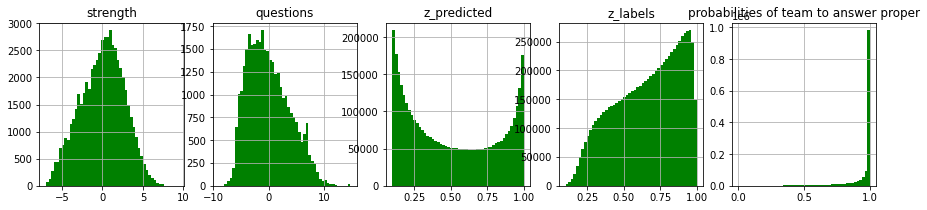

1
probability for team to answer proper: 0.4386770163496068
E ended
M ended
model weight:
[ 4.03554138  4.52638212  4.75598949 ... -1.46499626 -1.46436544
 -1.46436544]
stregth min, max 9.99832415545334 -6.030389465457146
question complexity min, max 15.464492268569543 -8.00254561618727
kendell = 0.6498150920738481
spirman = 0.8053335775034924
mse weight pred and current 0.18933509494161482
mse predicted and labels 0.023566684058876457


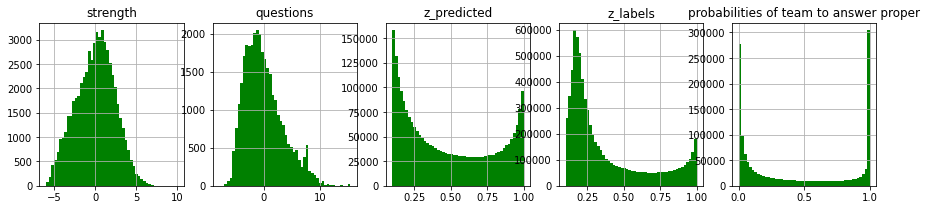

2
probability for team to answer proper: 0.31032518982467006
E ended
M ended
model weight:
[ 3.80022708  4.22586778  4.46204661 ... -1.44298241 -1.44248429
 -1.44248429]
stregth min, max 10.183806821876237 -5.741640218910506
question complexity min, max 15.624947116456212 -7.548885938925447
kendell = 0.6562917412875088
spirman = 0.8102343371325499
mse weight pred and current 0.044827869422980164
mse predicted and labels 0.016984669898651026


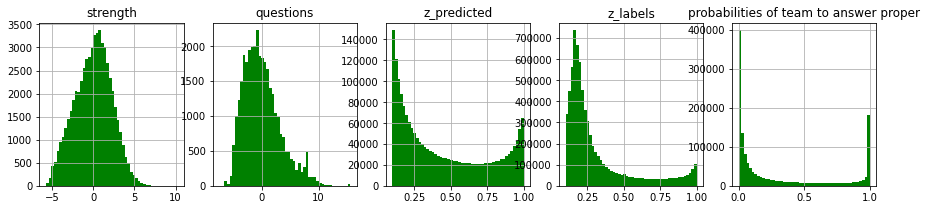

3
probability for team to answer proper: 0.26225174294496073
E ended
M ended
model weight:
[ 3.72006467  4.11801802  4.36853408 ... -1.44611524 -1.44560721
 -1.44560721]
stregth min, max 10.589441874037385 -5.647118985540644
question complexity min, max 15.675742076600299 -7.348676882875425
kendell = 0.6583234617242013
spirman = 0.8117228086348927
mse weight pred and current 0.011177201778251591
mse predicted and labels 0.015367365416719717


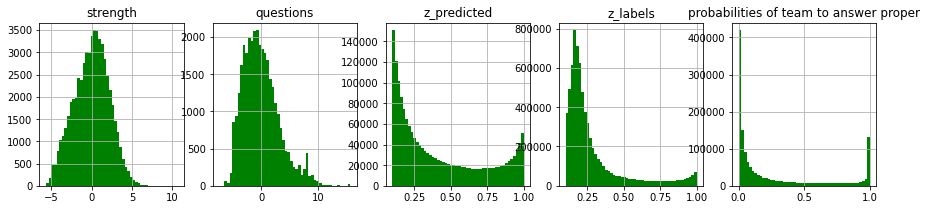

4
probability for team to answer proper: 0.24061654256271073
E ended
M ended
model weight:
[ 3.69170574  4.07794463  4.34304165 ... -1.45003716 -1.44952481
 -1.44952481]
stregth min, max 11.331115077718723 -5.612275214050154
question complexity min, max 15.698294851923245 -7.257845394396754
kendell = 0.6585016038748831
spirman = 0.811960207119406
mse weight pred and current 0.00393979454838442
mse predicted and labels 0.014840676746599472


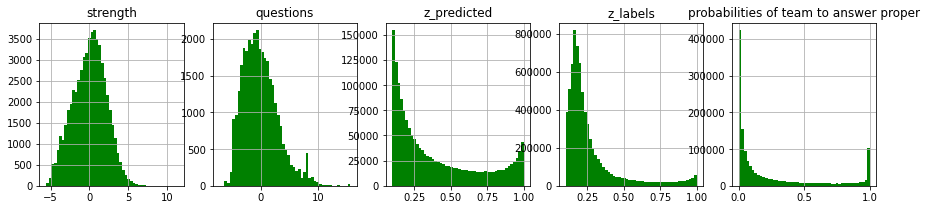

5
probability for team to answer proper: 0.22978746647858325
E ended
M ended
model weight:
[ 3.68051694  4.06094683  4.33786205 ... -1.45386023 -1.4533462
 -1.4533462 ]
stregth min, max 11.937695646368343 -5.5979365596410355
question complexity min, max 15.711046516198696 -7.212554036317558
kendell = 0.6589524290800365
spirman = 0.8123385636573884
mse weight pred and current 0.001773919533881226
mse predicted and labels 0.014643061511002418


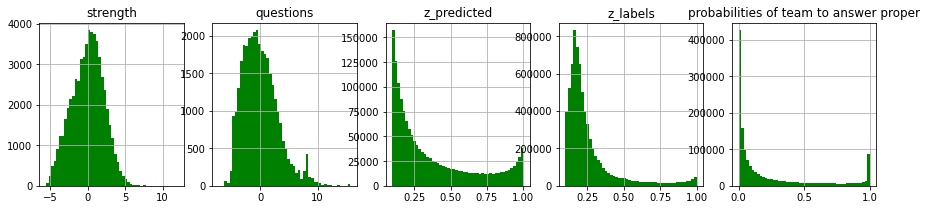

6
probability for team to answer proper: 0.22386910197131363
E ended
M ended
model weight:
[ 3.67549781  4.05263495  4.33837694 ... -1.45766119 -1.4571464
 -1.4571464 ]
stregth min, max 12.42687697268783 -5.591245212768308
question complexity min, max 15.719096007739351 -7.187421839737739
kendell = 0.6589695250303569
spirman = 0.8123083452655329
mse weight pred and current 0.0009309361990235508
mse predicted and labels 0.0145620194262269


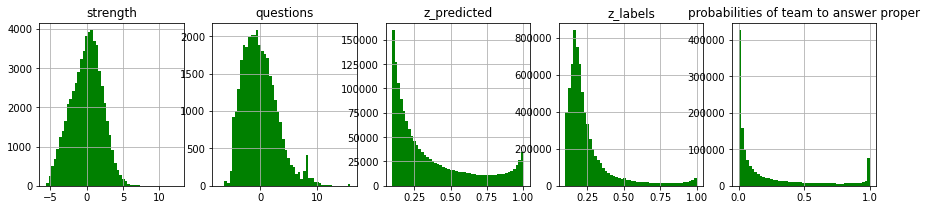

7
probability for team to answer proper: 0.2203969591076245
E ended
M ended
model weight:
[ 3.67288005  4.04801742  4.34012236 ... -1.46143229 -1.46091706
 -1.46091706]
stregth min, max 12.81956540426786 -5.587636128244132
question complexity min, max 15.724473236803396 -7.172061693954418
kendell = 0.6590751842370801
spirman = 0.8124025690847755
mse weight pred and current 0.0005431330458647595
mse predicted and labels 0.014526548719662238


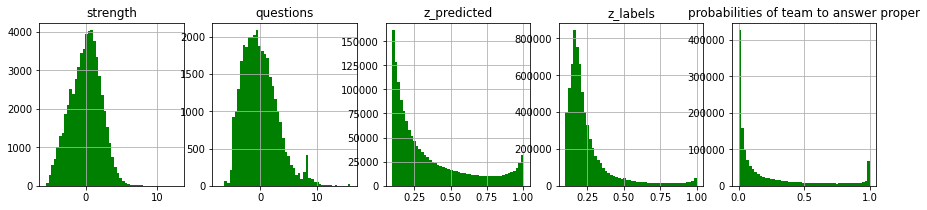

8
probability for team to answer proper: 0.21823453316221308
E ended
M ended
model weight:
[ 3.6712878   4.04516985  4.34178465 ... -1.46514418 -1.46462861
 -1.46462861]
stregth min, max 13.134468939856784 -5.5853883503837665
question complexity min, max 15.728231668401834 -7.161892168176205
kendell = 0.6593655250424392
spirman = 0.8127062642119487
mse weight pred and current 0.00033581875569543216
mse predicted and labels 0.014510352210628772


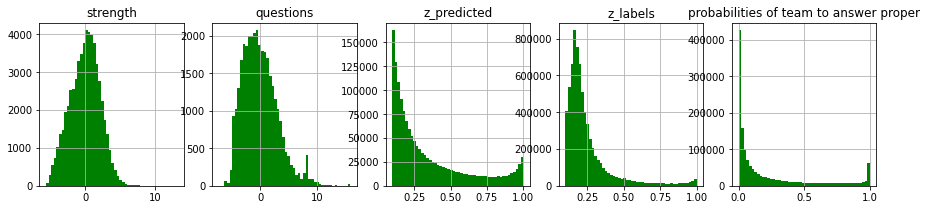

9
probability for team to answer proper: 0.21681674191810826
E ended
M ended
model weight:
[ 3.67016551  4.04324463  4.34303075 ... -1.46878016 -1.46826429
 -1.46826429]
stregth min, max 13.387141003545208 -5.583835698683796
question complexity min, max 15.730982523372854 -7.154723558053632
kendell = 0.6595986195213084
spirman = 0.8129010022137508
mse weight pred and current 0.00022330184122856486
mse predicted and labels 0.014502971692800647


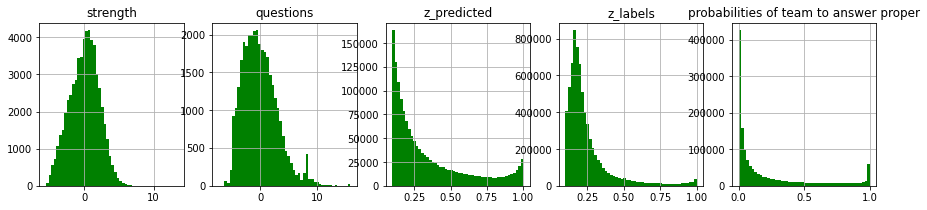

10
probability for team to answer proper: 0.21584746920669956
E ended
M ended
model weight:
[ 3.66929863  4.04185467  4.34385879 ... -1.47232636 -1.47181022
 -1.47181022]
stregth min, max 13.660980294310319 -5.582680065713675
question complexity min, max 15.733077741489748 -7.149426293244955
kendell = 0.6597118170158621
spirman = 0.8130444143602341
mse weight pred and current 0.00015297088027951922
mse predicted and labels 0.014499890917993606


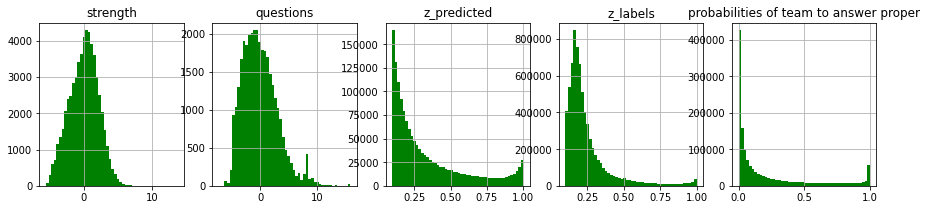

11
probability for team to answer proper: 0.21516348553588924
E ended
M ended
model weight:
[ 3.66859749  4.04080355  4.34436059 ... -1.47577162 -1.47525524
 -1.47525524]
stregth min, max 13.864643108848057 -5.581777658409914
question complexity min, max 15.7347415185032 -7.145373865727526
kendell = 0.6596917765316807
spirman = 0.8130199923496739
mse weight pred and current 0.00010701541980943298
mse predicted and labels 0.014498968065355665


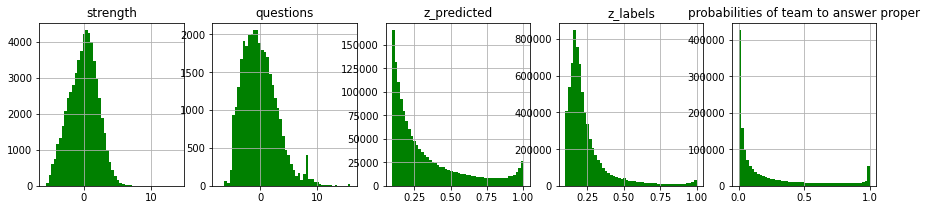

12
probability for team to answer proper: 0.21466948716665982
E ended
M ended
model weight:
[ 3.66802436  4.03998777  4.34463668 ... -1.47911188 -1.47859528
 -1.47859528]
stregth min, max 13.925143776994965 -5.581046045787554
question complexity min, max 15.73609089788091 -7.142195384040853
kendell = 0.6597164267492738
spirman = 0.8129738892064964
mse weight pred and current 7.450344157880469e-05
mse predicted and labels 0.014499109848991271


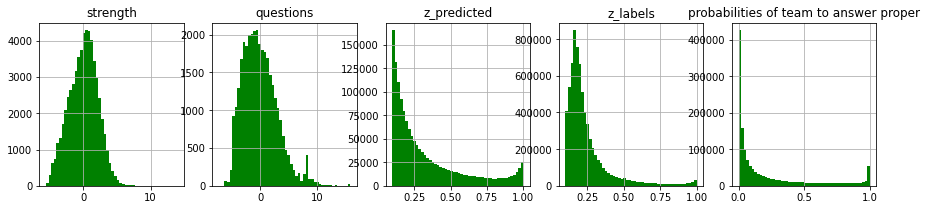

13
probability for team to answer proper: 0.2143063634432262
E ended
M ended
model weight:
[ 3.66755108  4.03934013  4.34475313 ... -1.48235137 -1.48183455
 -1.48183455]
stregth min, max 13.992448607457694 -5.58044221090851
question complexity min, max 15.737179862242307 -7.139656718507938
kendell = 0.6596634613040488
spirman = 0.8129046891776299
mse weight pred and current 5.334167273195392e-05
mse predicted and labels 0.014499749419564735


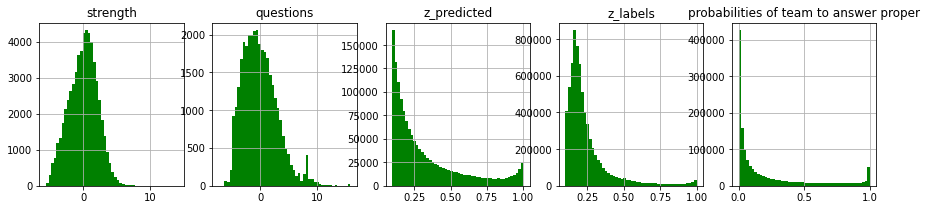

14
probability for team to answer proper: 0.21403559164964647
E ended
M ended
model weight:
[ 3.66715628  4.03881549  4.34478642 ... -1.48548996 -1.48497295
 -1.48497295]
stregth min, max 14.07894598519642 -5.579940234511632
question complexity min, max 15.738076095784209 -7.137600922828401
kendell = 0.6597149962513468
spirman = 0.8129607910124127
mse weight pred and current 3.888715110921909e-05
mse predicted and labels 0.014500581032127813


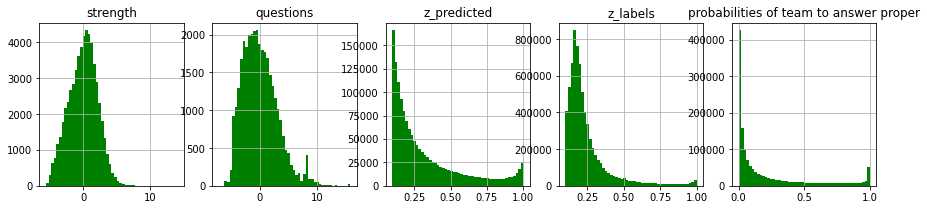

15
probability for team to answer proper: 0.2138311068457853
E ended
M ended
model weight:
[ 3.666827    4.03838537  4.34475933 ... -1.48852998 -1.48801279
 -1.48801279]
stregth min, max 14.149129174647394 -5.579517180297545
question complexity min, max 15.73881993942535 -7.1359156690964936
kendell = 0.659690419843456
spirman = 0.8129202767992019
mse weight pred and current 2.9312458275584666e-05
mse predicted and labels 0.014501462850089129


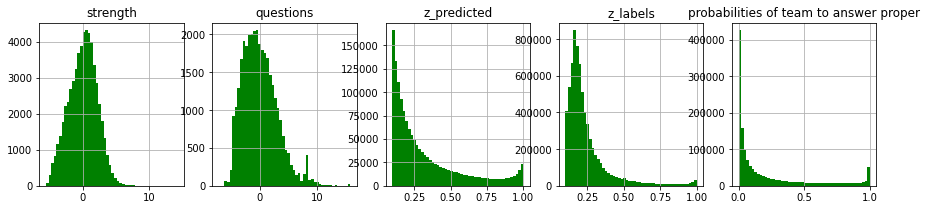

16
probability for team to answer proper: 0.21367516767614303
E ended
M ended
model weight:
[ 3.66655482  4.03803189  4.34469869 ... -1.49147546 -1.49095811
 -1.49095811]
stregth min, max 14.206126112897365 -5.579156836750367
question complexity min, max 15.73943745381902 -7.134520683599098
kendell = 0.6597335090248826
spirman = 0.8131034384371946
mse weight pred and current 2.266528949363839e-05
mse predicted and labels 0.014502317774832497


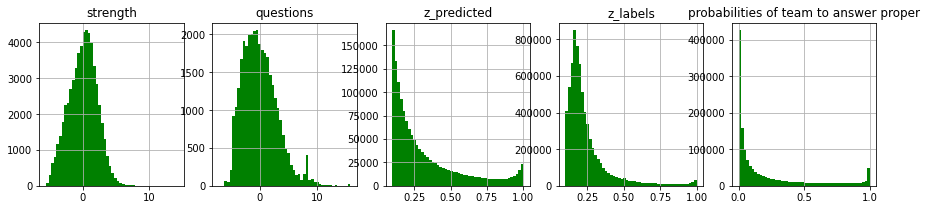

17
probability for team to answer proper: 0.21355515991505197
E ended
M ended
model weight:
[ 3.66632603  4.03774059  4.3446237  ... -1.49433124 -1.49381372
 -1.49381372]
stregth min, max 14.252431218768187 -5.578846683237876
question complexity min, max 15.739944364550258 -7.13335614661565
kendell = 0.6586532857035686
spirman = 0.8125759543292047
mse weight pred and current 1.794282618644921e-05
mse predicted and labels 0.014503106720246777


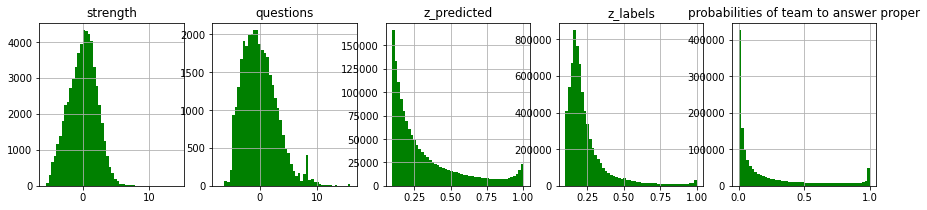

18
probability for team to answer proper: 0.2134619950777425
E ended
M ended
model weight:
[ 3.66613684  4.03750059  4.34454058 ... -1.49710055 -1.49658289
 -1.49658289]
stregth min, max 14.289172535652678 -5.578577123381986
question complexity min, max 15.74036173558152 -7.1323760959872455
kendell = 0.6582272117319939
spirman = 0.8122391917950333
mse weight pred and current 1.4522804377730077e-05
mse predicted and labels 0.014503811715371703


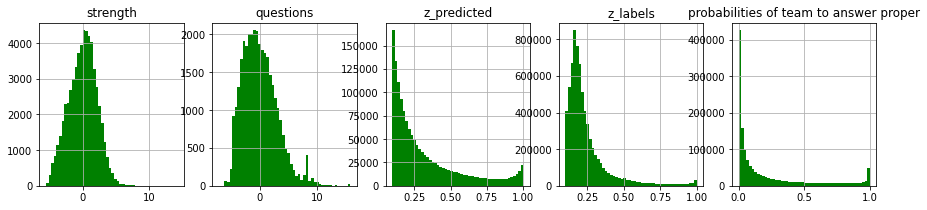

19
probability for team to answer proper: 0.2133890560278028
E ended
M ended
model weight:
[ 3.66598087  4.0373033   4.34445855 ... -1.499787   -1.4992692
 -1.4992692 ]
stregth min, max 14.318007643839083 -5.578340660413064
question complexity min, max 15.74070603462702 -7.131545149879451
kendell = 0.6582894480547551
spirman = 0.8124366878225109
mse weight pred and current 1.200123859390218e-05
mse predicted and labels 0.014504430028854844


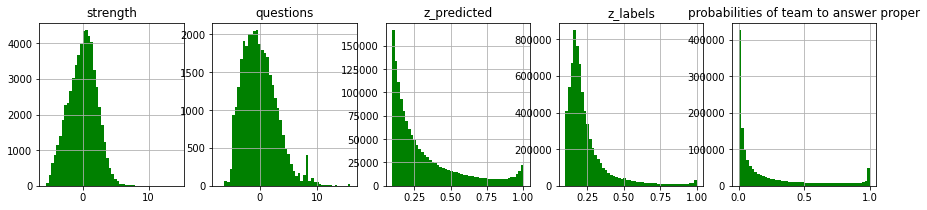

20
probability for team to answer proper: 0.21333147674017905
E ended
M ended
model weight:
[ 3.66585264  4.03714164  4.34438056 ... -1.50239384 -1.50187591
 -1.50187591]
stregth min, max 14.34013926314153 -5.578131395079316
question complexity min, max 15.740993107485108 -7.1308357639693085
kendell = 0.6583083881651309
spirman = 0.8124434143307808
mse weight pred and current 1.010639810883617e-05
mse predicted and labels 0.014504967484438917


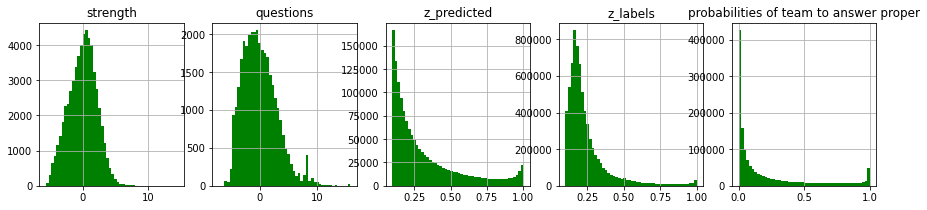

21
probability for team to answer proper: 0.21328565482871198
E ended
M ended
model weight:
[ 3.66574759  4.03700426  4.34430875 ... -1.50492519 -1.50440712
 -1.50440712]
stregth min, max 14.356926497510187 -5.577944558749902
question complexity min, max 15.741230092217798 -7.1302263985494685
kendell = 0.6583152692280568
spirman = 0.8124456816849652
mse weight pred and current 8.647904334601348e-06
mse predicted and labels 0.014505435881826583


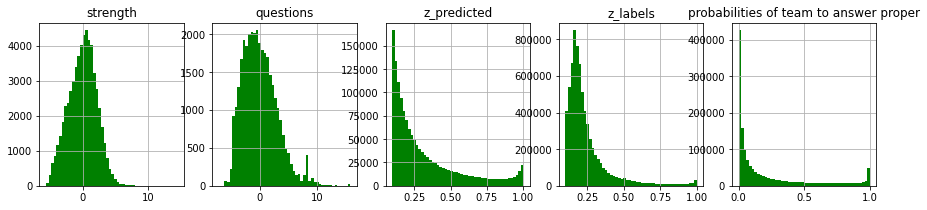

In [ ]:
for i in range(0, 22):
  print(i)
  sigma_y_pred_prev = sigma_y_pred.copy()
  
  if i > 0:
    target_lin_pred = target_lin.copy()
    weight_pred = model.coef_;
  target_lin, p_all, mean = EMcycle(sigma_y_pred)
  if i != 0:  
    with open(f'/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/models/model{i+1}.pkl','rb') as f:
      model = pickle.load(f)
      kendel = pickle.load(f)
      spirman= pickle.load(f)
      metric1 = pickle.load(f)
      metric2 = pickle.load(f)
      mean = pickle.load(f)
  else:
    target_lin, p_all, mean = EMcycle(sigma_y_pred)
    model = LR1().fit(matrix, target_lin)
  print("probability for team to answer proper:", mean)
  print("E ended")
  #model = LR1().fit(matrix, target_lin)

  
  print("M ended")
  #print("logit(target):")
  #print(target_lin[0:20])  
  y_pred = model.predict(matrix)
  sigma_y_pred = list(map(sigma, y_pred))
  sigma_zakaz = list(map(sigma, target_lin))
  print("model weight:")
  print(model.coef_)

  strengths0 = model.coef_[0 : len(ids)]
  maxp = max(strengths0)
  minp = min(strengths0)
  #print(maxp, minp)
  print("stregth min, max", maxp, minp)

  questions0 = model.coef_[len(ids):]
  maxp = max(questions0)
  minp = min(questions0)
  print("question complexity min, max", maxp, minp)


  models.append(model)
  strengths = model.coef_[0 : len(ids)]
  coeff1, coeff2 =   get_mean_range_coeff(ids_2020_new, strengths)
  kendel.append(coeff1)
  spirman.append(coeff2)
  print(f"kendell = {np.mean(coeff1)}")
  print(f"spirman = {np.mean(coeff2)}")
   
  metric1 = metrics.mean_squared_error(sigma_y_pred, sigma_zakaz)
  metric2 = 0
  if i > 0:
    metric2 = metrics.mean_squared_error(weight_pred, model.coef_)
    metric2_list.append(metric2)
    print(f"mse weight pred and current {metric2}")
  metric1_list.append(metric1)
  
  print(f"mse predicted and labels {metric1}")
  
  
  #with open(f'/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/model{i+1}.pkl','wb') as f:
   #  pickle.dump(model,f)
    # pickle.dump(kendel,f)
    # pickle.dump(spirman,f)
    # pickle.dump(metric1,f)
    # pickle.dump(metric2,f)
    # pickle.dump(mean,f)
  
  questions = model.coef_[len(ids):]    
  sigma_y_pred_not_null = filter(lambda x: x > 0.1, sigma_y_pred)
  sigma_zakaz_not_null = filter(lambda x: x > 0.1, sigma_zakaz)
  plot_hist2(strengths, questions, sigma_y_pred_not_null, sigma_zakaz_not_null, p_all)

На каждой итерации выводим следующие характеристики:
*   probability for team to answer proper - cредняя вероятность правильного ответа в случае, когда команда ответила правильно
*   model weight - веса модели на данном шаге
*   stregth min, max, question complexity - Диапазон изменения сил игроков и сложностей вопросов
*   kendell, spirman - метрики в виде ранговых корреляция рассчитанных для турниров 2020 года
*   mse predicted and labels - среднее квадратичное разности меток логрегрессии и предсказанных моделью значений на данной итерации
*   mse weight pred and current. Для оценки сходимости  - среднеквадратичное разности весов модели на предыдущей и последующей итерациях











Строим графики зависимостей этих данных от итерации

In [ ]:
metric1_lists = []
metric2_lists = []
means = []
interсepts = []
for i in range(1,22):
  with open(f'/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/models/model{i+1}.pkl','rb') as f:
     model = pickle.load(f)
     kendel = pickle.load(f)
     spirman= pickle.load(f)
     metric1 = pickle.load(f)
     metric2 = pickle.load(f)
     mean = pickle.load(f)
#     kendels.append(kendel)
#     spirmans.append(spirman)
     metric1_lists.append(metric1)
     metric2_lists.append(metric2)
     interсepts.append(model.intercept_)
     means.append(mean)



  

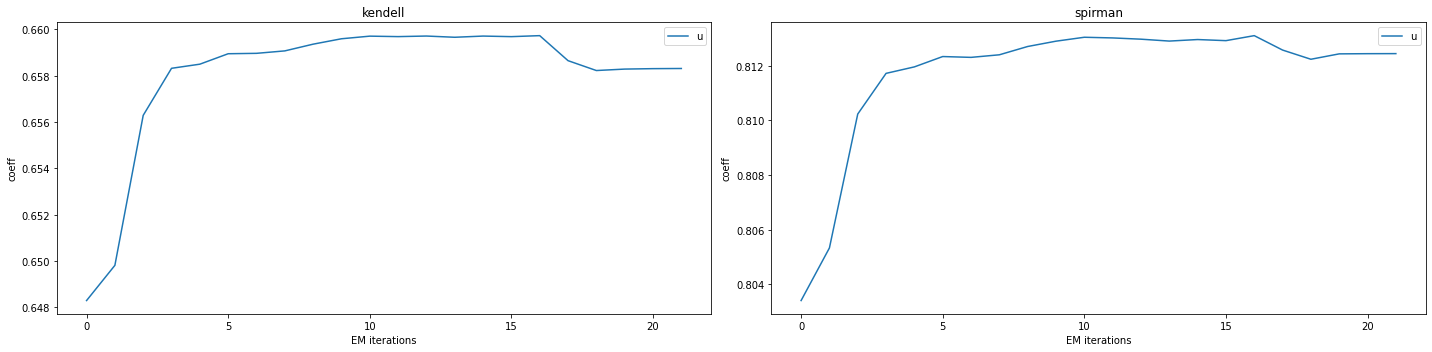

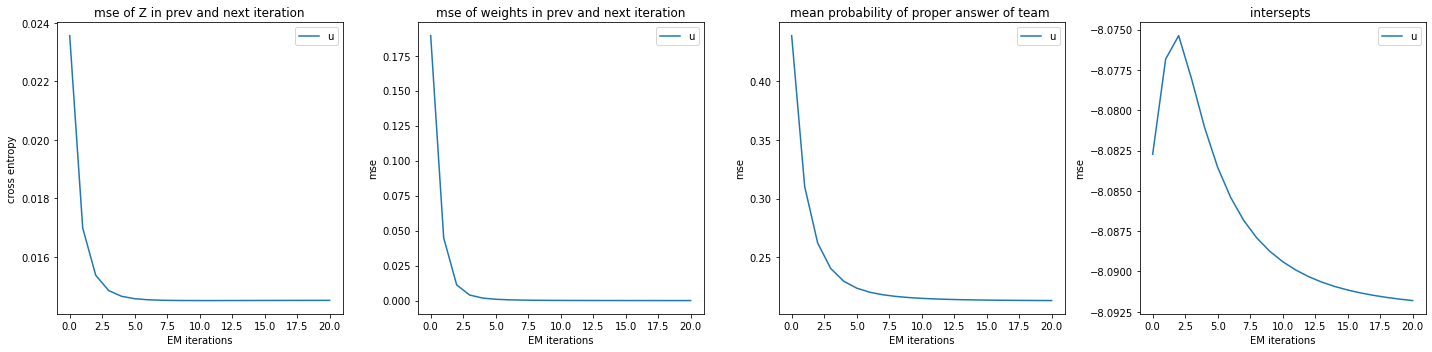

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
plot_one_curve(list(map(statistics.mean, kendel)), "kendell", "coeff", "EM iterations", axes[0])
plot_one_curve(list(map(statistics.mean, spirman)), "spirman", "coeff", "EM iterations", axes[1])

fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
plot_one_curve(metric1_lists, "mse of Z in prev and next iteration", "cross entropy", "EM iterations",axes[0])
plot_one_curve(metric2_lists, "mse of weights in prev and next iteration", "mse", "EM iterations", axes[1])
plot_one_curve(means, "mean probability of proper answer of team ", "mse", "EM iterations", axes[2])
plot_one_curve(interсepts, "intersepts ", "mse", "EM iterations", axes[3])

Процесс сходится к некоторым значениям весов (среднее квадратичное разности весов на последующих итерациях -> 0). Где-то на 15 итерации ранговые корреляции начинают уменьшаться. Веса уже сошлись, а свободный член interсept еще меняется, из-за этого меняются ранговые корреляции.

В идеальном варианте после того, как процесс сошелся,  мы ожидали получить такие веса модели, что вероятность ответить команду правильно был достаточно близко к 1. При этом в дроби 
$$\frac{\sigma(p_i + q_j + b)}{1 - \prod\limits_{i=1}{(1 - \sigma(p_i + q_j + b))}}$$
в знаменетеле мы бы получили значение, близкое к 1. В случае, если бы полученные из логрегрессии данные и заказанные данные совпадали бы, то процесс сошелся бы нужным нам образом и вероятность команд ответить на вопрос верно стремился к 1.
Но на деле метки (z_labels) и предсказанные значения (z_predicted) не совпадают.
И средняя вероятность правильного ответа команд для случаев правильных ответов получается довольно низкой.
Понятно, что найденные значения весов не являются"самыми лучшими", но дают прирост к ранговым корреляциям.
В моем понимании, самые "лучшие" веса можно оценить, если найти максимум правдоподобия данныx всеx вопросов турниров 2019. Но реализовать это сложно, ЕМ алгоритм является способом приблизиться к глобальному максимуму данной функции.

$$ ln(P(X | \theta))  = ln(\prod\limits_{k,j=1}(p(x_kj | \theta)) = \sum\limits_{k=1}ln(p(x_{kj} | \theta))$$
где:

$$ p(x_{kj} | \theta) = 1 - \prod\limits_{i = 1}(1 - \sigma(p_i + q_j + b))$$ если $x_k = 1$
$$p(x_{kj} | \theta) = \prod\limits_{i = 1}(1 - \sigma(p_i + q_j + b))$$ если $x_k = 0$


Посмотрим улучшается ли модель с каждой итерацией по этому критерию

In [ ]:
def estimate_model(sigma_y_pred):
  cur_h = 0
  cur_w = len(ids)
  target = [] 
  p_all = []  
  F = 0
  for id_tur in turs:
     for i in range(tournament_info[id_tur].shape[0]):
       players_in_team = tournament_info[id_tur].loc[i, 'sostav']
       mask = tournament_info[id_tur].loc[i, "mask"]
       if (len(players_in_team) == 0):
         continue
       for q in range(nquestions[id_tur]):
         if mask[q] == '1':
           P = 0  
           for player in players_in_team:
              P += np.log( 1 - sigma_y_pred[p_q_to_index[index_player[player], cur_w + q]])
         else:
           P = 0  
           for player in players_in_team:
              P += np.log( 1 - sigma_y_pred[p_q_to_index[index_player[player], cur_w + q]])
           
         F += P 
     cur_w += nquestions[id_tur]           
  return F

In [ ]:
y_pred = model.predict(matrix)
sigma_y_pred = list(map(sigma, y_pred))
result1 = estimate_model(sigma_y_pred)

y_pred = model0.predict(matrix)
sigma_y_pred = list(map(sigma, y_pred))
result2 = estimate_model(sigma_y_pred)

print(f"{result1}", result2)

In [ ]:
results1 = []
results2 = []

y_pred = model0.predict(matrix)
sigma_y_pred = list(map(sigma, y_pred))
result2 = estimate_model(sigma_y_pred)


for i in range(1,22):
  with open(f'/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/models/model{i+1}.pkl','rb') as f:
     model = pickle.load(f)

     y_pred = model.predict(matrix)
     sigma_y_pred = list(map(sigma, y_pred))
     result1 = estimate_model(sigma_y_pred)
     results1.append(result1)
     results2.append(result2)


#print(f"{result1}", result2)

Построим график зависимости данного критерия от итерации

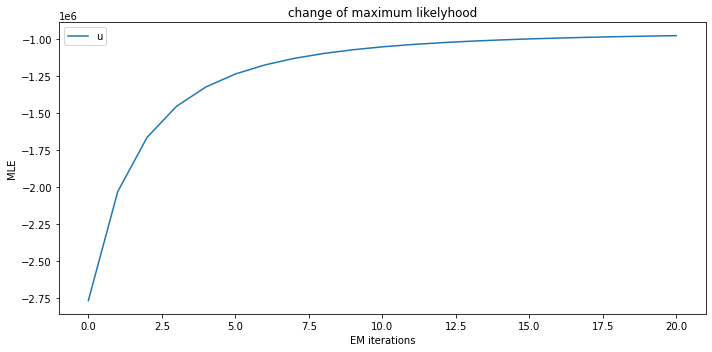

In [ ]:
fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
plot_one_curve(results1, "change of maximum likelyhood", "MLE", "EM iterations", axes)


Мы видимо рост MLE с увеличением количества итераций. 

Для сравнения, значение MLE для baseline модели

In [ ]:
print(result2)

-17028662.72946046


Из всех моделек выберем ту, для которых ранговые корреляции самые лучшие:


In [ ]:
mean_spirman = list(map(statistics.mean, spirman))
mean_kendel = list(map(statistics.mean, kendel))
ibest = mean_spirman.index(max(mean_spirman))
print(ibest)
print(mean_spirman[ibest])
print(mean_kendel[ibest])

10
0.813044414360234
0.6597118170158621


Теперь посмотрим как лучшая ЕМ-модель оценила турниры 2019 года по сложности. Сложность турнира будем рассчитывать как среднюю сложность вопроса по всему турниру.

In [ ]:
with open(f'/content/drive/MyDrive/MADE/semester2/AdvancedML/Task2/models/model10.pkl','rb') as f:
     model = pickle.load(f)
     kendel = pickle.load(f)
     spirman= pickle.load(f)
     metric1 = pickle.load(f)
     metric2 = pickle.load(f)
     mean = pickle.load(f)
#     kendels.append(kendel)
#     spirmans.append(spirman)
     #metric1_lists.append(metric1)
     #metric2_lists.append(metric2)
     #means.append(mean)

In [ ]:
def get_tournament_complexity(turs, model):
  tdata = pd.DataFrame(columns = ["id", "name", "complexity"])
  cur_w = len(ids)                     
  for id_tur in turs:
    sum = 0    
    for q in range(nquestions[id_tur]):                       
       sum += model.coef_[cur_w + q]
    tdata = tdata.append({"id": id_tur, "name" : tournaments[id_tur]['name'], "complexity" : sum/nquestions[id_tur]},ignore_index=True)  
    cur_w += nquestions[id_tur]       
  #print(tdata.head())  
  return tdata 
          #tdata.append({"id": i, "name" : tournaments[i], model.coef[cur_w + q]})  
  #for i in range(ids):
  #    tdata.append({"id": i, "name" : tournaments[i], tournament_info[i][mask]})
  #return tdata    

tdata = get_tournament_complexity(turs, model)


Посмотрим самый "легкие" и самые "сложные" турниры в 2019 году

In [ ]:
print(tdata.nlargest(100, 'complexity').head(20))

       id                                              name  complexity
652  6102                                  One ring - async    6.286617
318  5438                               Синхрон Лиги Разума    4.222473
346  5013            (а)Синхрон-lite. Лига старта. Эпизод V    3.949106
599  5457    Студенческий чемпионат Калининградской области    3.839033
295  5706           (а)Синхрон-lite. Лига старта. Эпизод XI    3.750404
587  5955                           Школьная лига. III тур.    3.671748
539  5936                             Школьная лига. I тур.    3.656731
612  5012                 Школьный Синхрон-lite. Выпуск 2.5    3.614480
633  5705                 Школьный Синхрон-lite. Выпуск 3.5    3.582509
589  6254                                     Школьная лига    3.549359
351  5702           (а)Синхрон-lite. Лига старта. Эпизод IX    3.546408
426  5698          (а)Синхрон-lite. Лига старта. Эпизод VII    3.542744
453  5009          (а)Синхрон-lite. Лига старта. Эпизод III    3

In [ ]:
print(tdata.nsmallest(100, 'complexity').head(20))

       id                                     name  complexity
373  6149  Чемпионат Санкт-Петербурга. Первая лига   -4.806596
274  5928                              Угрюмый Ёрш   -3.509407
127  5684               Синхрон высшей лиги Москвы   -3.099397
218  6101                       Воображаемый музей   -2.957248
24   5159             Первенство правого полушария   -2.931042
496  5942         Чемпионат Мира. Этап 2. Группа В   -2.832845
363  5465                         Чемпионат России   -2.815470
505  5941         Чемпионат Мира. Этап 2. Группа А   -2.765756
130  5693                         Знание – Сила VI   -2.748299
529  5946         Чемпионат Мира. Этап 3. Группа В   -2.692195
12   5083                        Ускользающая сова   -2.686358
92   5587                         Записки охотника   -2.682688
461  5515  Чемпионат Минска. Лига А. Тур четвёртый   -2.656742
407  5930   Зеркало мемориала памяти Михаила Басса   -2.648998
528  5943          Чемпионат Мира. Этап 2 Группа С   -2

Посколько какой-то известной заранее числовой характеристики сложности турнира нет, то посчитать насколько модель адекватно оценила сложности турниров не получится, но из здравого смысла видно, что модель довольно неплохо справилась со своей задачей (школьные турниры оценены как самые легкие, а чемпионаты мира как самые сложные)

Также посмотрим, как у нас изменился top-50 для игроков 

In [ ]:
estimate_range_of_players(model, 1)

kendall for all players 0.6249897103923251
spirman for all players 0.8157770803884792
kendall for top-100 0.27195503054233966
spirman for top-100 0.38528795864043075
                    fio_model            fio_right  n_questions for fio_model
11054        Максим Пилипенко       Артём Сорожкин                         36
16440           Ольга Козлова         Иван Семушин                         36
5315               Илья Немец     Михаил Савченков                         75
9024        Светлана Гусарова       Сергей Спешков                        111
12896          Анна Печёнкина         Максим Руссо                         72
18321         Сергей Завьялов    Александра Брутер                         36
19521          Феликс Фрайман      Александр Либер                         36
17272         Сергей Короткий        Алексей Гилёв                         45
16755          Андрей Козенко         Юрий Выменец                         36
12213         Галина Лазарева     Сергей Коновалов    

top-50 стал намного хуже, чем был для baseline. Очень много игроков практически с нулевым опытом (1-2 турнира)

Бонус-7:

Теперь о рейтинге. Рейтингом должна быть такая величина, которая с одной стороны должна учитывать текущую силу игрока, то есть его способность выиграть у игроков с такими же или чуть ниже рейтингами. С другой стороны он должен учитывать и опыт, (то есть если человек участвовал в одном турнире и всех обыграл - это не значит, что его рейтинг тут же станет большим), причем так, что если у игрока есть уже большое значение рейтинга и он почему-либо стал менее сильным, то поиграв какое-то небольшое число игр его рейтинг бы стал меньше и быстро спустился до нужного уровня, и наоборот, если человек был когда-то слабым, но допустим повысил свою силу и не играл какой-то период, то мог бы довольно быстро набрать себе рейтинг.
Исходя из этого, можно преположить, что рейтинг это накапливаемая величина, причем чем больше разность между существующей силой человека и его реальной силой на данный момент, тем быстрее он наберет эту разность за некоторое количество турниров.
Таким образом,  нужно определить некую функцию, позволяющуюу рассчитать, какое изменение рейтинга произошло у игрока за один турнир.

Попробуем определить эту функцию. 
Рассмотрим турнир, где играют $k = 1 .. n$ команд с участниками с  силами $p_{1k}$ ... $p_{n_kk}$
Пусть существует функция $P_k = P(p_{1k}$, ... $p_{n_kk}$), которая определяет силу команды, исходя из сил ее участников. Она должна быть идентична силе  некоего игрока, который может сыграть в ничью или обыграть каждого из участников этой команды.

Определим вероятность того, что один игрок обыграет второго (на основе формулы рейтинга Эло), как $$p(i, j) = \frac{1} {1 + 10^{(pi - pj)/400}}$$
  
Пусть этот собирательный образ игрок J с силой pteam равен по силе команде.
Тогда вероятность, что он выиграет у всех членов команды равна произведению вероятностей выиграть у каждого из ее членов, приравняем вероятности (0.5):
  $$\prod\limits_{k=1}(p(k, J)) = 0.5$$
Отсюда сможем оценить силу команду pteam.

В результате турнира пусть каждый участник получит изменение рейтинга (одинаковое для всех участников команды) по каждому вопросу пропорциональное числу команд с бОльшим рейтингом, у которых команда этого человека выиграла в данном вопросе минус количество команд с меньшим рейтингом, у которых команда проиграла. Все изменения рейтингов умножаются на такой коэффициент, чтобы суммарный рейтинг всех участников остался неизменным.

**Бонус-6**:

Может быть попробовать такую идею, что каждый человек, начиная играть уже считается проигравшим по некоторому количеству вопросов. Постепенно, наращивая свой опыт, он "заменяет" нулевые ответы, на реальные. Таким образом, его рейтинг растет и он видит свой результат, но при этом игроки, которые отыграли уже этот минимум вопросов имеют преимущества по сравнению с такими новичками.
Попробуем просто разбавить табличку из baseline такими вот фиктивными вопросами. И посмотрим, что произойдет с top-100.

In [ ]:
player_nquest = {id : sum(list(map(lambda x: nquestions[x], players_info[id]))) for id in ids}

In [ ]:
from  scipy.sparse import csr_matrix

p_q_to_index = {}

def get_matrix_corrected(ids):
   turs = []
   w = 0
   h = 0
   
   for id in ids:#[0:idmax]:
     for id_tur in players_info[id]:
       if id_tur not in turs:
         turs.append(id_tur)
   
   
   cur_h = 0
   cur_w = 0
   cases = 0
   k = 0
   data = []
   row = []
   columns = []
   cur_w = len(ids)
   column_names = {}
   target = []
   
   for id_tur in turs:
     #print(id_tur)
     tournament_info[id_tur].index
     id_teams =  tournament_info[id_tur]['id'].tolist()
     #print(id_teams)


     for i in range(tournament_info[id_tur].shape[0]):
       players_in_team = tournament_info[id_tur].loc[i, 'sostav']
       mask = tournament_info[id_tur].loc[i, "mask"]
       cases += nquestions[id_tur] * len(players_in_team)
       if mask is None:
           continue
       if (len(players_in_team) == 0):
          continue    
       for player in players_in_team:
         for q in range(nquestions[id_tur]):
           column_names.update({cur_w + q : str(id_tur) + "_" + str(q)})
         for q in range(nquestions[id_tur]):
           data.append(1)
           columns.append(index_player[player])
           row.append(cur_h)
           data.append(1)
           columns.append(cur_w + q)
           row.append(cur_h)
           target.append(mask[q])
           p_q_to_index.update({(index_player[player], cur_w + q) : cur_h})
           cur_h += 1
           
     cur_w += nquestions[id_tur]    
   for id in ids:
     if player_nquest[id] < 100:
       for i in range (100 - player_nquest[id]):
          data.append(1)
          columns.append(index_player[id])
          row.append(cur_h)
          data.append(1)
          columns.append(cur_w + 1)
          row.append(cur_h)
          target.append(int(mask[q]))
       #p_q_to_index.update({(index_player[id], cur_w + 1) : cur_h})
          cur_h += 1
   matrix = csr_matrix((data, (row, columns)))
   
   return cases, matrix, column_names, target

In [ ]:
cases_new, matrix_new, column_names_new, target_New = get_matrix_corrected(ids)

In [ ]:
print(matrix_new.shape)
print(len(target_New))

(17966106, 91327)
17966106


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
model_new = LR(solver = 'saga').fit(matrix_new, target_New)

In [ ]:
estimate_range_of_players(model_new, 0)